# Baysian Two-way Fixed Effects

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [3]:
filepath = '../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df

,island_ids,year,pseudo_year,region_codes,prefecture_codes,population,treatment_group,treatment_group_mainland,bridge_year,pseudo_bridge_year,...,area_km2,distance_m,elementary_school,junior_high_school,high_school,hospital,log_pop,time_since_treatment,pseudo_time_since_treatment,pseudo_after_treatment
0,67,1970,1970,32202,32,NaN,1,1,1999,1999,...,0.28,615.0,NaN,NaN,NaN,NaN,NaN,-29,-29,0
1,67,1975,1975,32202,32,NaN,1,1,1999,1999,...,0.28,615.0,NaN,NaN,NaN,NaN,NaN,-24,-24,0
2,67,1980,1980,32202,32,NaN,1,1,1999,1999,...,0.28,615.0,NaN,NaN,NaN,NaN,NaN,-19,-19,0
3,67,1985,1985,32202,32,NaN,1,1,1999,1999,...,0.28,615.0,NaN,NaN,NaN,NaN,NaN,-14,-14,0
4,67,1990,1990,32202,32,NaN,1,1,1999,1999,...,0.28,615.0,NaN,NaN,NaN,NaN,NaN,-9,-9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852,226,2000,2000,39424,39,398.0,1,1,1957,1957,...,0.56,110.0,NaN,NaN,NaN,NaN,5.986452,43,43,1
1853,226,2005,2005,39424,39,365.0,1,1,1957,1957,...,0.56,110.0,NaN,NaN,NaN,NaN,5.899897,48,48,1
1854,226,2010,2010,39424,39,343.0,1,1,1957,1957,...,0.56,110.0,NaN,NaN,NaN,NaN,5.837730,53,53,1
1855,226,2015,2015,39424,39,284.0,1,1,1957,1957,...,0.56,110.0,NaN,NaN,NaN,NaN,5.648974,58,58,1


## TWFE

$$
\begin{aligned}
\log{Y_{it}} &\sim \mathcal{t}(\nu=3, \mu_{it}, \sigma^2) \\
\mu_{it} &= \text{intercept} + \beta \cdot T_{it} + \text{islands}_i + \text{year}_{t} \\
\sigma &\sim \text{Half-}\mathcal{t}(\nu=3, 1) \\
\text{intercept} &\sim \mathcal{N}(0, 1) \\
\beta &\sim \mathcal{N}(0, 1) \\
\text{island}_i &\sim \mathcal{N}(0, 1) \\
\text{year}_t &\sim \mathcal{N}(0, 1) \\
\end{aligned}
$$

## Studet't分布

自由度パラメータ: $\nu = 3$

### ベイズモデル

##### モデルの定義

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


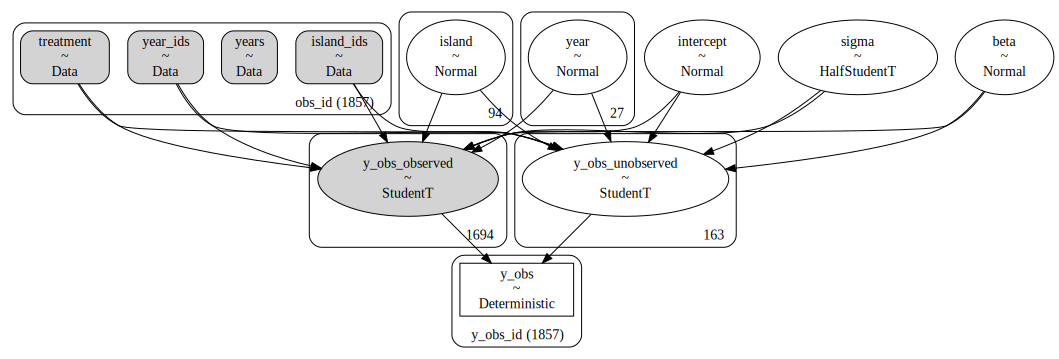

In [10]:
# 0から始まるインデックスを振り直す
island_ids, unique_island_ids = pd.factorize(df['island_ids'])
year_ids, unique_year_ids = pd.factorize(df['year'])

COORDS = {'obs_id': df.index, 'y_obs_id': df.index}

with pm.Model(coords=COORDS) as twfe_student_t:
    # data
    island_ids = pm.Data('island_ids', island_ids, dims='obs_id')
    year_ids = pm.Data('year_ids', year_ids, dims='obs_id')
    years = pm.Data('years', df['year'], dims='obs_id')
    treatment = pm.Data('treatment', df['pseudo_after_treatment'], dims='obs_id')

    # priors
    # random effects
    island = pm.Normal('island', mu=0, sigma=1, shape=len(unique_island_ids))
    year = pm.Normal('year', mu=0, sigma=1, shape=len(unique_year_ids))

    # fixed effects
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=1)

    # expectation
    mu = intercept + beta * treatment + island[island_ids] + year[year_ids]

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['log_pop'], dims='y_obs_id')

pm.model_to_graphviz(twfe_student_t)

##### サンプリング

In [11]:
with twfe_student_t:
    initvals = {'intercept': 5, 'beta': 0.1, 'sigma': 0.1}
    trace_twfe_student_t = pm.sample(
        draws=2000,
        tune=1000,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=123,
        initvals=initvals,
    )

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


##### 結果の確認

In [12]:
az.summary(trace_twfe_student_t, hdi_prob=.95, var_names=['intercept', 'beta', 'sigma'])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,5.740,0.235,5.269,6.173,0.02,0.014,141.0,282.0,1.02
beta,0.165,0.021,0.126,0.210,0.00,0.000,3428.0,2610.0,1.00
sigma,0.116,0.003,0.110,0.122,0.00,0.000,4375.0,2915.0,1.00


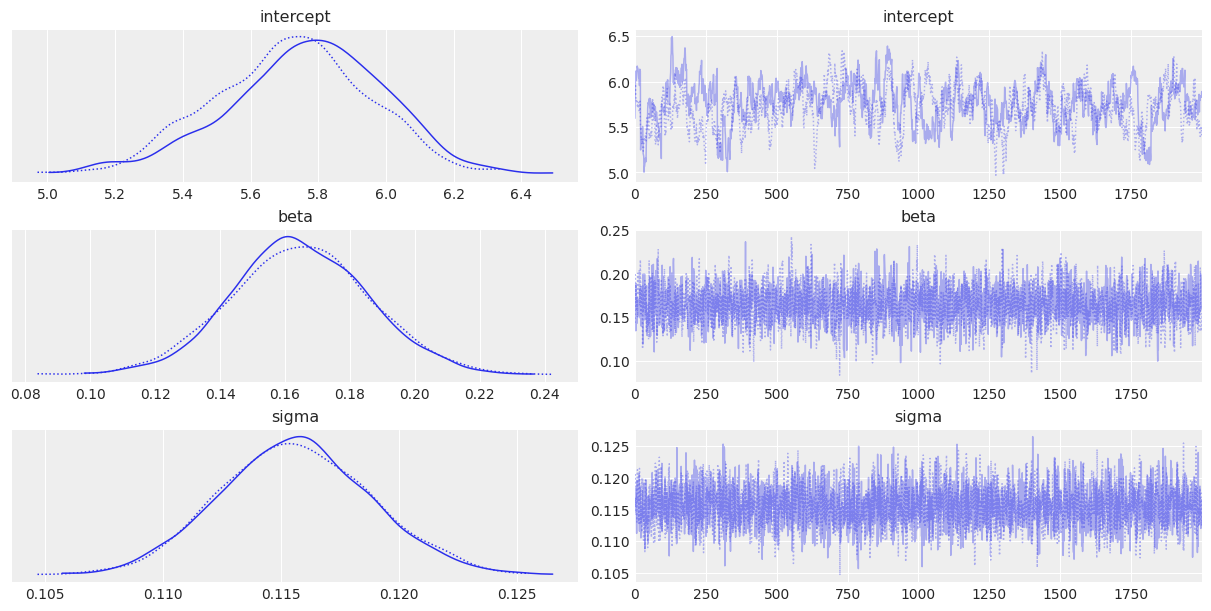

In [13]:
az.plot_trace(trace_twfe_student_t, var_names=['intercept', 'beta', 'sigma']);

In [14]:
with twfe_student_t:
    pm.compute_log_likelihood(trace_twfe_student_t)

Output()

In [15]:
az.waic(trace_twfe_student_t)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 1694 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   421.24    55.64
p_waic      164.66        -

There has been a warning during the calculation. Please check the results.

### 階層ベイズモデル

##### モデルの定義

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


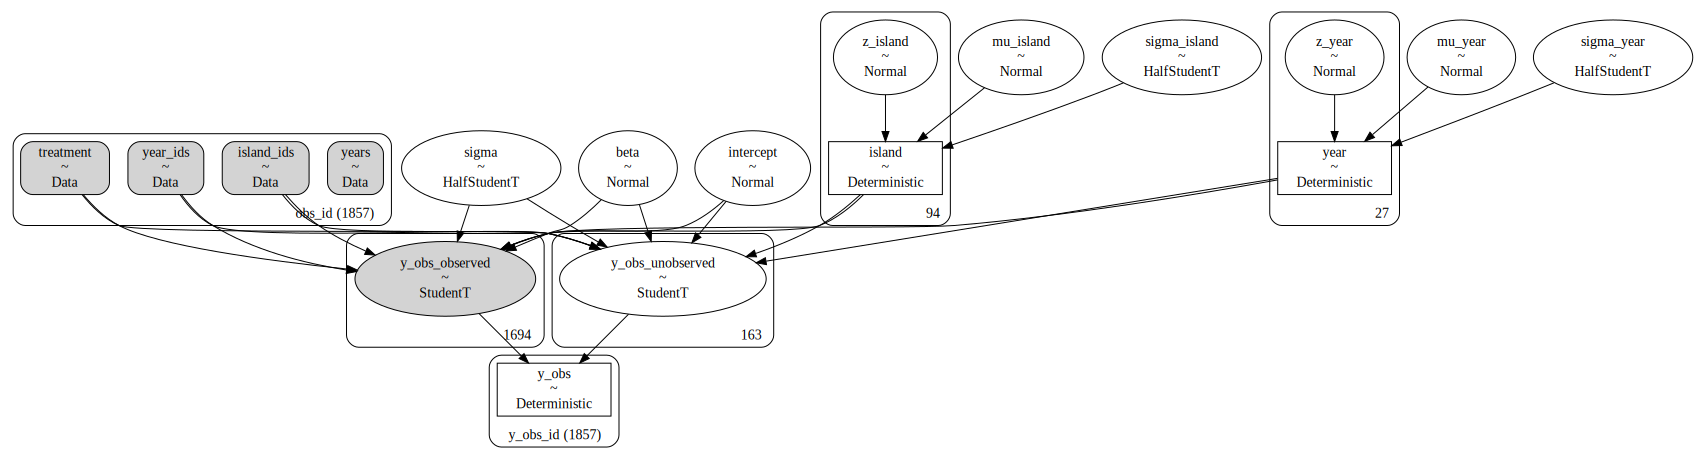

In [10]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_islandds = pd.factorize(df['island_ids'])
df['year_ids'], unique_year_ids = pd.factorize(df['year'])

COORDS = {
    'obs_id': df.index,
    'y_obs_id': df.index
}

with pm.Model(coords=COORDS) as twfe_h_student_t:
    # data
    island_ids = pm.Data('island_ids', df['island_ids'], dims='obs_id')
    year_ids = pm.Data('year_ids', df['year_ids'], dims='obs_id')
    years = pm.Data('years', df['year'], dims='obs_id')
    treatment = pm.Data('treatment', df['pseudo_after_treatment'], dims='obs_id')

    # priors
    # random effects
    mu_island = pm.Normal('mu_island', mu=0, sigma=1)
    sigma_island = pm.HalfStudentT('sigma_island', nu=3, sigma=1)
    z_island = pm.Normal('z_island', mu=0, sigma=1, shape=len(unique_islandds))
    island = pm.Deterministic('island', mu_island + sigma_island * z_island)

    mu_year = pm.Normal('mu_year', mu=0, sigma=1)
    sigma_year = pm.HalfStudentT('sigma_year', nu=3, sigma=1)
    z_year = pm.Normal('z_year', mu=0, sigma=1, shape=len(unique_year_ids))
    year = pm.Deterministic('year', mu_year + sigma_year * z_year)

    # fixed effects
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=100)

    # expectation
    mu = pm.math.exp(intercept + beta * treatment + island[island_ids] + year[year_ids])

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['log_pop'], dims='y_obs_id')

pm.model_to_graphviz(twfe_h_student_t)

##### サンプリング

In [12]:
with twfe_h_student_t:
    initvals = {'intercept': 1.7, 'beta': 0.1, 'sigma': 0.1}
    trace_twfe_h_student_t = pm.sample(
        draws=1000,
        tune=100,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42,
        initvals=initvals,
    )

  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


##### 結果の確認

In [13]:
az.summary(trace_twfe_h_student_t, hdi_prob=.95, var_names=['intercept', 'beta', 'sigma'])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.771,1.152,-1.366,2.755,0.570,0.436,4.0,82.0,1.41
beta,0.034,0.004,0.026,0.042,0.000,0.000,307.0,526.0,1.01
sigma,0.155,0.005,0.145,0.165,0.001,0.001,35.0,46.0,1.04


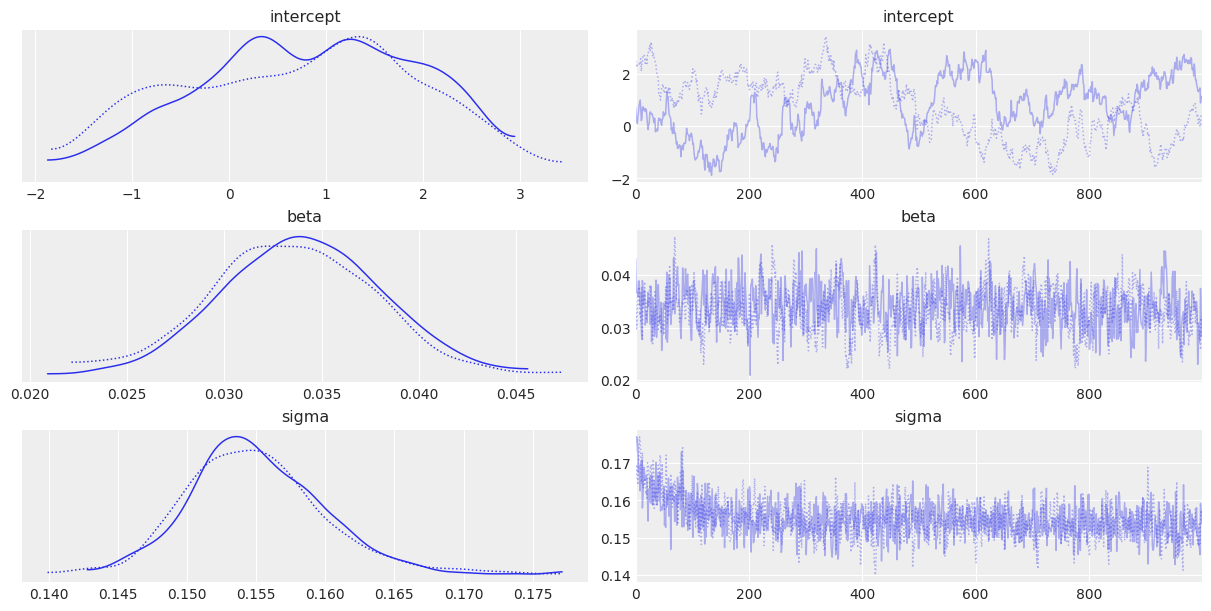

In [14]:
az.plot_trace(trace_twfe_h_student_t, var_names=['intercept', 'beta', 'sigma']);

In [28]:
with twfe_h_student_t:
    pm.compute_log_likelihood(trace_twfe_h_student_t)

Output()

In [29]:
az.waic(trace_twfe_h_student_t)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 1694 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   429.05    55.83
p_waic      157.75        -

There has been a warning during the calculation. Please check the results.

## サンプリングの保存

In [16]:
az.to_netcdf(trace_twfe_student_t, './sample/traces_twfe_student_t_log.nc')
# az.to_netcdf(trace_twfe_h_student_t, './sample/traces_twfe_h_student_t_log.nc')

'./sample/traces_twfe_student_t_log.nc'

## サンプリングのインポート

In [ ]:
trace_twfe = az.from_netcdf('./sample/traces_twfe_log.nc')
trace_twfe_h = az.from_netcdf('./sample/traces_twfe_h_log.nc')
trace_twfe_student_t = az.from_netcdf('./sample/traces_twfe_student_t_log.nc')
trace_twfe_h_student_t = az.from_netcdf('./sample/traces_twfe_h_student_t_log.nc')